In [5]:
"""
Simulation of two groups (control vs. "OCD-like") using a dynamic-criterion SDT model.

Model:
    y_t ~ Bernoulli( f( w^T u_t + x_t ) )

where:
    - u_t : input vector on trial t
    - w   : weights on the inputs
    - x_t : latent decision criterion, modeled as an AR(1) process
    - f   : logistic link function (sigmoid)

Design:
    - The underlying (true) sensitivity d' is identical in both groups.
    - The OCD-like group has larger criterion fluctuations:
        * higher standard deviation of the AR(1) noise term ε
        * autoregressive parameter a closer to 1
    - After simulating responses, we fit a classical SDT model with a static criterion and examine observed d' and confidence for each subject.
"""


'\nSimulation of two groups (control vs. "OCD-like") using a dynamic-criterion SDT model.\n\nModel:\n    y_t ~ Bernoulli( f( w^T u_t + x_t ) )\n\nwhere:\n    - u_t : input vector on trial t\n    - w   : weights on the inputs\n    - x_t : latent decision criterion, modeled as an AR(1) process\n    - f   : logistic link function (sigmoid)\n\nDesign:\n    - The underlying (true) sensitivity d\' is identical in both groups.\n    - The OCD-like group has larger criterion fluctuations:\n        * higher standard deviation of the AR(1) noise term ε\n        * autoregressive parameter a closer to 1\n    - After simulating responses, we fit a classical SDT model with a static criterion and examine observed d\' and confidence for each subject.\n'

In [6]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import pandas as pd
from metadpy.mle import metad 


### Classical SDT: compute d' and criterion c from hits and false alarms

In [7]:
def compute_dprime(stim, resp):
    """
    Compute d' and decision criterion c from a yes/no SDT task.

    Parameters
    ----------
    stim : array-like of int
        Stimulus labels per trial.
        0 = noise, 1 = signal.
    resp : array-like of int
        Binary responses per trial.
        0 = "no", 1 = "yes".

    Returns
    -------
    d_prime : float
        Sensitivity index d'.
    c : float
        Decision criterion.
    """
    stim = np.asarray(stim)
    resp = np.asarray(resp)

    # Hit rate: P("yes" | signal)
    hit_rate = np.mean(resp[stim == 1] == 1)
    # False alarm rate: P("yes" | noise)
    fa_rate = np.mean(resp[stim == 0] == 1)

    # Avoid 0 or 1 (would send z to ±∞)
    # Had to ask AI
    eps = 1e-4
    hit_rate = np.clip(hit_rate, eps, 1-eps)
    fa_rate = np.clip(fa_rate, eps, 1-eps)

    zH = norm.ppf(hit_rate)
    zF = norm.ppf(fa_rate)

    d_prime = zH - zF
    c = -.5 * (zH + zF)

    return d_prime, c


### Logistic link function

In [8]:
def logistic(z):
    return 1.0/(1.0 + np.exp(-z))

### Simulate a single subject: $y_t$ ~ Bernoulli( f( $w^T$ $u_t$ + $x_t$ ) )

In [9]:
def simulate_subject(
        n_trials = 1000,
        n_inputs = 3,
        a = .9,
        sigma_eps = .3,
        b = 0,
        w = None,
        p_signal = .5,
        d_true = 1.5, 
        seed = None
):
    """
    Simulate one subject under a dynamic-criterion SDT model.

    Latent process:
        x_t = b + a * x_{t-1} + eps_t          (AR(1) decision criterion)
        z_t = w^T u_t + x_t                    (linear predictor)
        p_t = logistic(z_t)
        y_t ~ Bernoulli(p_t)

    Inputs:
        - We keep a 0/1 stimulus code for SDT analyses (stim: 0 = noise, 1 = signal).
        - For the decision variable, we use a signed stimulus code: stim_signed = -1 (noise), +1 (signal),
          so that the two internal evidence distributions are symmetric around 0.

    Parameters
    ----------
    n_trials : int
        Number of trials to simulate.
    n_inputs : int
        Dimensionality of input vector u_t.
    a : float
        AR(1) autoregressive coefficient for the criterion x_t.
    sigma_eps : float
        Standard deviation of the AR(1) noise term ε_t.
    b : float
        Intercept of the AR(1) process.
    w : array-like or None
        Weight vector for the inputs. If None, only the first input (stimulus)
        is used with weight d_true; all other inputs are set to 0.
    p_signal : float
        Probability of a signal trial (P(stim=1)).
    d_true : float
        "True" underlying sensitivity parameter (used as weight on the stimulus input).
    seed : int or None
        Random seed for reproducibility.

    Returns
    -------
    result : dict
        Dictionary containing:
        - "y"      : responses (0/1)
        - "p"      : response probabilities
        - "x"      : latent criterion time series
        - "u"      : input matrix
        - "w"      : weight vector
        - "stim"   : 0/1 stimulus labels (for SDT)
        - "conf"   : confidence per trial, defined as |dv - x|
    """

    rng = np.random.default_rng(seed)

    # Stimulus for SDT: 0 = noise, 1 = signal
    stim = rng.binomial(1, p_signal, size = n_trials)

    # Signed stimulus for the decision variable: -1 (noise), +1 (signal)
    stim_signed = 2 * stim - 1 # 0 -> -1 and 1 -> +1

    # Weights w
    if w is None:
        w = np.zeros(n_inputs)
        # The first input is the (signed) stimulus, with weight equal to d_true
        w[0] = d_true

    # Inputs u: first column = signed stimulus, remaining columns = mean-centered noise covariates
    u = np.zeros((n_trials, n_inputs))
    u[:, 0] = stim_signed

    if n_inputs > 1:
        other = rng.normal(loc = 0.0, scale = 1.0, size = (n_trials, n_inputs-1))
        other -= other.mean(axis = 0, keepdims = True) # mean-center each column
        u[:, 1:] = other

    # Latent criterion x_t (AR(1) process)
    x = np.zeros(n_trials) 
    x[0] = 0.0
    for t in range(1, n_trials):
        eps_t = rng.normal(loc = 0.0, scale = sigma_eps)
        x[t] = b + a * x[t-1] + eps_t

    # Linear predictor and response probabilities
    dv = u @ w #decision variable
    linpred = dv + x
    
    dv_noisy = dv + rng.normal(loc = 0.0, scale = 1.0, size = n_trials) #add gaussian noise

    # Binary responses y_t ~ Bernoulli(p_t)
    y = (dv_noisy > x).astype(int)

    # Confidence: distance between decision variable and current criterion
    conf = np.abs(dv_noisy-x)

    return {
        "y" : y,
        "x" : x,
        "u" : u,
        "w" : w,
        "stim" : stim,  # keep 0/1 code for classical SDT
        "conf" : conf   # |dv - x|
    }


### Simulate a group of subjects (control or OCD-like)

In [10]:
def simulate_group(
    n_subj = 30,
    n_trials = 1000,
    n_inputs = 3,
    a = .9,
    sigma_eps = .3,
    b = 0.0,
    d_true = 1.5,
    seed = 0
):
    
    """
    Simulate a group of subjects with shared AR(1) parameters, but different random seeds.

    Parameters
    ----------
    n_subj : int
        Number of subjects.
    n_trials : int
        Number of trials per subject.
    n_inputs : int
        Dimensionality of input vector u_t.
    a : float
        AR(1) autoregressive coefficient for the criterion x_t.
    sigma_eps : float
        Standard deviation of the AR(1) noise term ε_t.
    b : float
        Intercept of the AR(1) process.
    d_true : float
        "True" underlying sensitivity (weight on stimulus input).
    seed : int or None
        Seed for the group-level RNG that generates subject-level seeds.

    Returns
    -------
    subjects : list of dict
        Each element is the dictionary returned by `simulate_subject`
    """
    rng = np.random.default_rng(seed)
    subjects = []

    for i in range(n_subj):
        subj_seed = rng.integers(1e9) #zorgt voor willekeur
        sim = simulate_subject(
            n_trials= n_trials,
            n_inputs= n_inputs,
            a = a,
            sigma_eps= sigma_eps,
            b= b,
            w = None,
            p_signal= .5,
            d_true = d_true,
            seed = subj_seed
        )
        subjects.append(sim)
    return subjects

### Plot criterion fluctuations of some example criteria

In [11]:
def plot_example_criteria(control_subjects, OCD_subjects, n_examples = 3, n_trials_plot = 300):
    """
    plot criterion trajectories (x_t) for a few example subjects from each group,
    to visually inspect the AR(1) fluctuations.

     Parameters
    ----------
    control_subjects : list of dict
        Output of simulate_group(...) for the control group.
    OCD_subjects : list of dict
        Output of simulate_group(...) for the OCD-like group.
    n_examples : int
        Number of subjects to plot per group.
    n_trials_plot : int
        Number of initial trials to show (for readability).
    """
    n_examples = min(n_examples, len(control_subjects), len(OCD_subjects)) #To make sure that n_examples < number of simulations in both groups

    t = np.arange(n_trials_plot)

    # For layout AI was used to make things more pretty
    fig, axes = plt.subplots(2, n_examples, figsize=(4 * n_examples, 6), sharey=True)
    if n_examples == 1:
        # make sure axes is 2D indexable if n_examples == 1
        axes = np.array(axes).reshape(2, 1)

    for i in range(n_examples):
        # Control subject
        x_ctrl = control_subjects[i]["x"][:n_trials_plot]
        ax = axes[0, i]
        ax.plot(t, x_ctrl, label=f"control subj {i+1}")
        ax.axhline(0, color="k", linewidth=0.5, linestyle="--")
        ax.set_title(f"Control subj {i+1}")
        ax.set_xlabel("Trial")
        if i == 0:
            ax.set_ylabel("Criterion x_t")

        # OCD-like subject
        x_ocd = OCD_subjects[i]["x"][:n_trials_plot]
        ax = axes[1, i]
        ax.plot(t, x_ocd, label=f"OCD-like subj {i+1}", color="tab:red")
        ax.axhline(0, color="k", linewidth=0.5, linestyle="--")
        ax.set_title(f"OCD-like subj {i+1}")
        ax.set_xlabel("Trial")
        if i == 0:
            ax.set_ylabel("Criterion x_t")

    fig.suptitle("Example criterion trajectories (first trials)", fontsize=14)
    plt.tight_layout()
    plt.show()




### From continuous confidence to discrete ratings

In [12]:
# Not sure if this is a correct way to tackle this?

def conf_to_ratings(conf, n_ratings = 4):
    """
    Map continuous confidence values to discrete ratings
    using quantile-based binning.
    """
    conf = np.asarray(conf)

    #quantiles determine boundaries of the bins
    qs = np.linspace(0.0, 1.0, n_ratings + 1)
    bin_edges = np.quantile(conf, qs)

    ratings = np.digitize(conf, bin_edges[1:-1], right=True) + 1
    return ratings

### M-ratio

In [13]:
def compute_mratio(subj, n_ratings = 4, verbose = 0):
    """
    Compute meta-d' and m-ratio for a single simulated subject
    using metadpy (MLE).

    Returns
    -------
    m_ratio : float
        meta-d' / d' (metacognitive efficiency)
    meta_d  : float
        meta-d' estimate (optional, for inspection)
    """

    stim = np.asarray(subj["stim"]) #0/1 stimulus
    resp = np.asarray(subj["y"]) #0/1 respons
    conf_cont = np.asarray(subj["conf"])

    # Correctness of task
    accuracy = (stim == resp).astype(int)

    # 1) Exclude trivial/ill-posed cases
    acc_mean = accuracy.mean()
    if (acc_mean <= 0.05) or (acc_mean >= 0.95):
        return np.nan, np.nan
    
    # Exclude when no variation in confidence
    if np.allclose(conf_cont, conf_cont[0]):
        return np.nan, np.nan
    
    # Discretize confidence
    conf_rating = conf_to_ratings(conf_cont, n_ratings = n_ratings)

    # If only 1 rating class is used, meta-d' also has no info
    if np.unique(conf_rating).size < 2:
        return np.nan, np.nan
    
    # Build trial-wise DataFrame
    df = pd.DataFrame({
        "Stimuli" : stim,
        "Accuracy" : accuracy,
        "Confidence": conf_rating
    })

    try: #(used AI for the try and except)
        #Fit meta d'
        results = metad(
            data = df,
            nRatings = n_ratings,
            stimuli = "Stimuli",
            accuracy = "Accuracy",
            confidence = "Confidence",
            verbose = verbose
        )
    except Exception as e:
        # Catch e.g., ZeroDivisionError / convergence errors
        # and return NaN so the grid continues
        return np.nan, np.nan

    #results
    m_ratio = float(results["m_ratio"].iloc[0])
    meta_d = float(results["meta_d"].iloc[0])

    return m_ratio, meta_d

### Investigating parameters in a more systematic way

In [14]:
def param_grid(
    a_values,
    sigma_values,
    n_subj = 30,
    n_trials = 1000,
    n_inputs = 3,
    d_true = 1.5,
    seed = None
):
    """
    Systematically vary (a, sigma_eps) and compute mean d' and mean confidence, and mean m-ratio for each combination

    Parameters
    ----------
    a_values : list or array
        Values of AR(1) parameter a to explore.
    sigma_values : list or array
        Values of sigma_eps (SD of AR noise) to explore.
    n_subj : int
        Number of subjects per (a, sigma) combination.
    n_trials : int
        Number of trials per subject.

    Returns
    -------
    mean_d : array, shape (len(a_values), len(sigma_values))
        Mean d' for each (a, sigma) combination.
    mean_conf : array, shape (len(a_values), len(sigma_values))
        Mean confidence for each (a, sigma) combination.
    """
    #make sure they are the right data type
    a_values = np.asarray(a_values)
    sigma_values = np.asarray(sigma_values)

    #initiate zero "matrices"
    mean_d = np.zeros((len(a_values), len(sigma_values)))
    mean_conf = np.zeros((len(a_values), len(sigma_values)))
    mean_mratio = np.zeros((len(a_values), len(sigma_values)))

    rng = np.random.default_rng(seed)

    for i, a in enumerate(a_values):
        for j, sigma_eps in enumerate(sigma_values):

            # Different seed per cell, but reproducible across runs
            cell_seed = rng.integers(1e9)

            group = simulate_group(
                n_subj = n_subj,
                n_trials = n_trials,
                n_inputs = n_inputs,
                a = a,
                sigma_eps= sigma_eps,
                b = 0,
                d_true = d_true,
                seed = cell_seed
            )

            d_list = []
            conf_list = []
            mratio_list = []

            for subj in group:
                #d'
                d_prime, c = compute_dprime(subj["stim"], subj["y"])
                d_list.append(d_prime)

                #confidence
                conf_list.append(subj["conf"].mean())

                #m-ratio
                m_ratio, meta_d = compute_mratio(subj, n_ratings=4, verbose=0)
                mratio_list.append(m_ratio)

            d_list      = np.asarray(d_list)
            conf_list   = np.asarray(conf_list)
            mratio_list = np.asarray(mratio_list)

            mean_d[i,j] = np.mean(d_list)
            mean_conf[i,j] = np.mean(conf_list)

            # m-ratio: average over non-NaNs
            if np.all(np.isnan(mratio_list)):
                mean_mratio[i, j] = np.nan
            else:
                mean_mratio[i, j] = np.nanmean(mratio_list)

    return mean_d, mean_conf, mean_mratio

def plot_param_heatmaps(a_values, sigma_values, mean_d, mean_conf, mean_mratio):
     """
     Plot three heatmaps: mean d', mean confidence, and mean m-ratio as a function of (a, sigma_eps), using seaborn.heatmap.
     """

     #make sure they are the right data type
     a_values = np.asarray(a_values)
     sigma_values = np.asarray(sigma_values)

     #labels for axes (strings)
     x_labels = [f"{s:.2f}" for s in sigma_values]  # columns (sigma_eps)
     y_labels = [f"{a:.2f}" for a in a_values]      # rows (a) 

     fig, axes = plt.subplots(1,3, figsize = (16, 4))

     # -------------------------
     # Heatmap for mean d' (Little help from AI to figure Seaborn out)
     # -------------------------
     sns.heatmap(
        mean_d,
        ax=axes[0],
        annot=False,   # write/does not write values in the cells
        fmt=".2f",
        xticklabels=x_labels,
        yticklabels=y_labels,
        cbar_kws={"label": "mean d'"},
     )
     axes[0].set_xlabel("sigma_eps")
     axes[0].set_ylabel("a")
     axes[0].set_title("Mean d'")

     # -------------------------
     # Heatmap for mean confidence
     # -------------------------
     sns.heatmap(
        mean_conf,
        ax=axes[1],
        annot=False,
        fmt=".2f",
        xticklabels=x_labels,
        yticklabels=y_labels,
        cbar_kws={"label": "mean confidence"},
     )
     axes[1].set_xlabel("sigma_eps")
     axes[1].set_ylabel("a")
     axes[1].set_title("Mean confidence")
     
     # -------------------------
     # Heatmap for mean m-ratio
     # -------------------------
     sns.heatmap(
        mean_mratio,
        ax=axes[2],
        annot=False,
        fmt=".2f",
        xticklabels=x_labels,
        yticklabels=y_labels,
        cbar_kws={"label": "mean m-ratio"},
     )
     axes[2].set_xlabel("sigma_eps")
     axes[2].set_ylabel("a")
     axes[2].set_title("Mean m-ratio")

     fig.suptitle("Parametric effects of (a, sigma_eps) on d', confidence and m-ratio", fontsize=14)
     plt.tight_layout()
     plt.show()



### Main analysis: simulate both groups, compute SDT measures, and plot results

In [15]:

# -----------------------------
# Simulation parameters
# -----------------------------
n_subj = 50
n_trials = 1000
n_inputs = 3
d_true = 1.5

# Control group: smaller criterion fluctuations
a_control = .5
sigma_control = .15

# OCD-like group: larger criterion fluctuations
a_OCD = .95
sigma_OCD = .40

# -----------------------------
# Simulate both groups
# -----------------------------
control_subjects = simulate_group(
    n_subj= n_subj,
    n_trials= n_trials,
    n_inputs= n_inputs,
    a = a_control,
    sigma_eps= sigma_control,
    b = 0,
    d_true= d_true,
    seed = None
)

OCD_subjects = simulate_group(
    n_subj= n_subj,
    n_trials= n_trials,
    n_inputs= n_inputs,
    a = a_OCD,
    sigma_eps= sigma_OCD,
    b = 0,
    d_true= d_true,
    seed = None
)


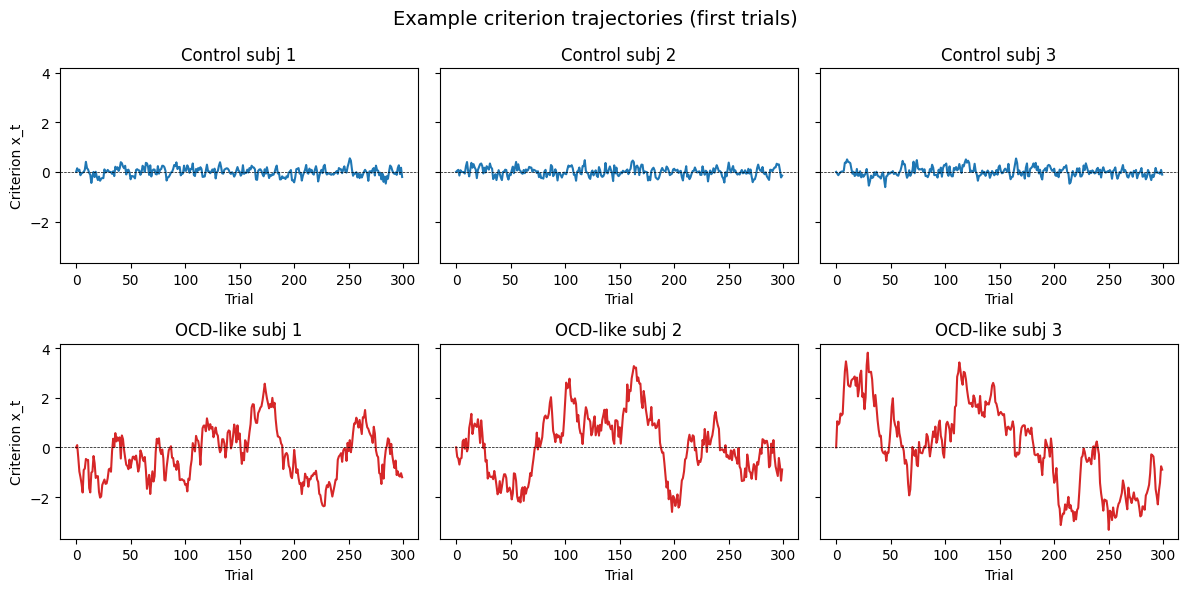

In [16]:

# -----------------------------
# plot some example subjects
# -----------------------------
plot_example_criteria(control_subjects, OCD_subjects, n_examples=3, n_trials_plot=300)


In [17]:

# -----------------------------
# Compute d' and mean confidence per subject
# -----------------------------

d_control = []
d_OCD = []
conf_mean_control = []
conf_mean_OCD = []
mratio_control = []
mratio_OCD = []


for subj in control_subjects:
    stim = subj["stim"]
    resp = subj["y"]
    d_prime, c = compute_dprime(stim, resp)
    d_control.append(d_prime)
    conf_mean_control.append(subj["conf"].mean())

    m_ratio, meta_d = compute_mratio(subj, n_ratings = 4, verbose = 0)
    mratio_control.append(m_ratio)

for subj in OCD_subjects:
    stim = subj["stim"]
    resp = subj["y"]
    d_prime, c = compute_dprime(stim, resp)
    d_OCD.append(d_prime)
    conf_mean_OCD.append(subj["conf"].mean())

    m_ratio, meta_d = compute_mratio(subj, n_ratings=4, verbose=0)
    mratio_OCD.append(m_ratio)

d_control = np.array(d_control)
d_OCD = np.array(d_OCD)
conf_mean_control = np.array(conf_mean_control)
conf_mean_OCD = np.array(conf_mean_OCD)
mratio_control = np.array(mratio_control)
mratio_OCD = np.array(mratio_OCD)

print("--- Observed d' per group (classical SDT fit) ---")
print(f"Control: mean d' = {d_control.mean():.3f}, SD = {d_control.std():.3f}")
print(f"OCD:     mean d' = {d_OCD.mean():.3f}, SD = {d_OCD.std():.3f}")

print("--- Mean confidence per group ---")
print(
    f"Control: mean conf = {conf_mean_control.mean():.3f}, "
    f"SD = {conf_mean_control.std():.3f}"
)
print(
    f"OCD:     mean conf = {conf_mean_OCD.mean():.3f}, "
    f"SD = {conf_mean_OCD.std():.3f}"
)
print("--- Mean m-ratio per group ---")
print(
    f"Control: mean m-ratio = {mratio_control.mean():.3f}, "
    f"SD = {mratio_control.std():.3f}"
)
print(
    f"OCD:     mean m-ratio = {mratio_OCD.mean():.3f}, "
    f"SD = {mratio_OCD.std():.3f}"
)
# -----------------------------
# Compute observed c per group
# -----------------------------

c_control = []
c_OCD = []

for subj in control_subjects:
    d_prime, c = compute_dprime(subj["stim"], subj["y"])
    c_control.append(c)

for subj in OCD_subjects:
    d_prime, c = compute_dprime(subj["stim"], subj["y"])
    c_OCD.append(c)

c_control = np.array(c_control)
c_ocd = np.array(c_OCD)

print("--- Observed c per group ---")
print(f"control: mean c = {np.mean(c_control):.3f}")
print(f"OCD:      mean c = {np.mean(c_OCD):.3f}")


--- Observed d' per group (classical SDT fit) ---
Control: mean d' = 2.987, SD = 0.111
OCD:     mean d' = 1.886, SD = 0.141
--- Mean confidence per group ---
Control: mean conf = 1.562, SD = 0.027
OCD:     mean conf = 1.798, SD = 0.056
--- Mean m-ratio per group ---
Control: mean m-ratio = 0.960, SD = 0.083
OCD:     mean m-ratio = 1.023, SD = 0.096
--- Observed c per group ---
control: mean c = 0.011
OCD:      mean c = -0.038


d': t = 42.916, p = 5.389e-63
Confidence: t = -26.632, p = 1.217e-38
M-ratio: t = -3.474, p = 7.706e-04


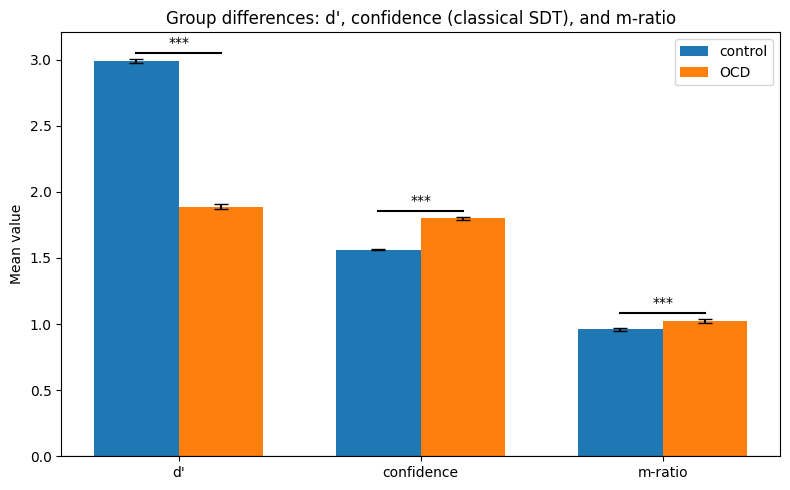

In [18]:

# -----------------------------
# Group-level t-tests (AI was used to figure this out)
# -----------------------------

tval_dprime, pval_dprime = ttest_ind(d_control, d_OCD, equal_var=False)
tval_conf, pval_conf = ttest_ind(conf_mean_control, conf_mean_OCD, equal_var=False)
tval_mratio, pval_mratio   = ttest_ind(mratio_control, mratio_OCD, equal_var=False)

print(f"d': t = {tval_dprime:.3f}, p = {pval_dprime:.3e}")
print(f"Confidence: t = {tval_conf:.3f}, p = {pval_conf:.3e}")
print(f"M-ratio: t = {tval_mratio:.3f}, p = {pval_mratio:.3e}")

# -----------------------------
# Bar plot: d', confidence by group, m-ratio by group (I had some help from AI here to figure out how to shape this nicely)
# -----------------------------

#Means
mean_d_control = d_control.mean()
mean_d_OCD  = d_OCD.mean()
mean_conf_control = conf_mean_control.mean()
mean_conf_OCD = conf_mean_OCD.mean()
mean_mratio_control = mratio_control.mean()
mean_mratio_OCD     = mratio_OCD.mean()

#Standard errors
se_d_control = d_control.std(ddof=1) / np.sqrt(len(d_control))
se_d_OCD  = d_OCD.std(ddof=1) / np.sqrt(len(d_OCD))
se_conf_control = conf_mean_control.std(ddof=1) / np.sqrt(len(conf_mean_control))
se_conf_OCD = conf_mean_OCD.std(ddof=1) / np.sqrt(len(conf_mean_OCD))
se_mratio_control = mratio_control.std(ddof=1) / np.sqrt(len(mratio_control))
se_mratio_OCD     = mratio_OCD.std(ddof=1) / np.sqrt(len(mratio_OCD))

#data in arrays
means_control = np.array([mean_d_control, mean_conf_control, mean_mratio_control])
means_OCD     = np.array([mean_d_OCD,     mean_conf_OCD,     mean_mratio_OCD])
ses_control   = np.array([se_d_control, se_conf_control, se_mratio_control])
ses_OCD       = np.array([se_d_OCD,     se_conf_OCD,     se_mratio_OCD])

labels = ["d'", "confidence", "m-ratio"]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(x - width/2, means_control, width, yerr=ses_control, capsize=5, label="control")
ax.bar(x + width/2, means_OCD,  width, yerr=ses_OCD,  capsize=5, label="OCD")

#formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Mean value")
ax.set_title("Group differences: d', confidence (classical SDT), and m-ratio")
ax.axhline(0, color="black", linewidth=0.8)
ax.legend()

# Significance stars helper
def p_to_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "n.s."

# Significance line for d'
y_max_d = max(means_control[0] + ses_control[0],
                means_OCD[0]  + ses_OCD[0])
y_sig_d = y_max_d + 0.05
ax.plot([x[0] - width/2, x[0] + width/2],
        [y_sig_d, y_sig_d], color="black")
ax.text(x[0], y_sig_d + 0.02, p_to_stars(pval_dprime),
        ha="center", va="bottom")

# Significance line for confidence
y_max_c = max(means_control[1] + ses_control[1],
                means_OCD[1]  + ses_OCD[1])
y_sig_c = y_max_c + 0.05
ax.plot([x[1] - width/2, x[1] + width/2],
        [y_sig_c, y_sig_c], color="black")
ax.text(x[1], y_sig_c + 0.02, p_to_stars(pval_conf),
        ha="center", va="bottom")

# Significance line for m-ratio
y_max_m = max(means_control[2] + ses_control[2],
                means_OCD[2]  + ses_OCD[2])
y_sig_m = y_max_m + 0.05
ax.plot([x[2] - width/2, x[2] + width/2],
        [y_sig_m, y_sig_m], color="black")
ax.text(x[2], y_sig_m + 0.02, p_to_stars(pval_mratio),
        ha="center", va="bottom")

plt.tight_layout()
plt.show()



Running parametric grid over (a, sigma_eps)...


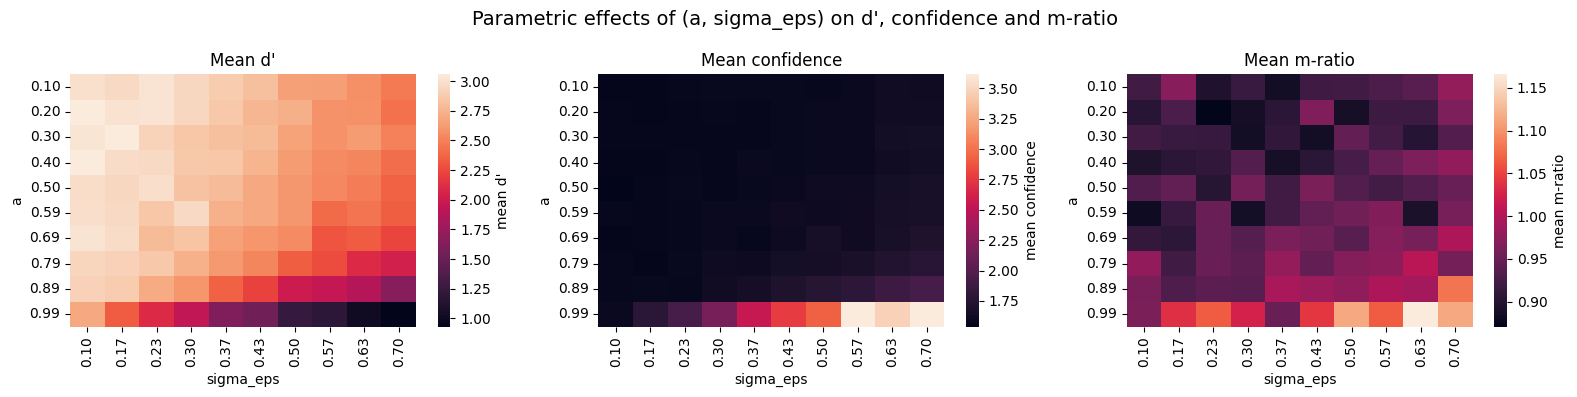

In [19]:
# -----------------------------
# Parametric grid: heatmaps over a x sigma_eps
# -----------------------------

# You can easily change these to a finer grid later
a_values = np.linspace(0.1, 0.99, 10)   # 10 values from 0.1 up and including 0.99
sigma_values = np.linspace(0.1, 0.70, 10)  # 10 values from 0.1 up and including .7

print("\nRunning parametric grid over (a, sigma_eps)...")
mean_d_grid, mean_conf_grid, mean_mratio_grid = param_grid(
        a_values=a_values,
        sigma_values=sigma_values,
        n_subj=30,          # you can increase this for smoother estimates
        n_trials=300,
        n_inputs=n_inputs,
        d_true=d_true,
        seed=None,
    )

plot_param_heatmaps(a_values, sigma_values, mean_d_grid, mean_conf_grid, mean_mratio_grid)